## Dataset Loading, Preprocessing

In [ ]:
!pip install gensim --upgrade

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/NLP/03")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ann_word2vec_12.h5	  word2vec.model
dataset-1.csv		  word2vec.model.syn1neg.npy
dataset-wiki.csv	  word2vec.model.wv.vectors.npy
label_encoder.pickle	  word2vec_wiki_12.model
lang-detect2.ipynb	  word2vec_wiki_12.model.syn1neg.npy
lang-detect3.ipynb	  word2vec_wiki_12.model.wv.vectors.npy
lang-detect4.ipynb	  word2vec-wiki-ann.h5
lang-detect-clean.ipynb   word2vec_wiki_ann.model
lang-detect.ipynb	  word2vec_wiki_lstm
tfidf-lstm-13.pickle	  word2vec-wiki-lstm.h5
tfidf-lstm-model-13.h5	  word2vec_wiki_lstm.model
tfidf-nb-14-model.pickle  word2vec_wiki.model.syn1neg.npy
tfidf-nb-14.pickle	  word2vec_wiki.model.wv.vectors.npy


In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("./dataset-wiki.csv")
df.head(5)

,Text,language
0,; † 1797) war Sohn eines Bauern und ist der St...,deu
1,; 1932 kehrte sich das Stimmenverhältnis zwisc...,deu
2,"; † 1981 in Brunsbüttel), Künstler; lebte und ...",deu
3,; 2014: Mit 2000 Besuchern wies das 5. Festiva...,deu
4,"; † 21. September 1902 in Lübeck), sein Vermögen.",deu


In [ ]:
df['language'].unique()

array(['deu', 'eng', 'fra', 'gle', 'ind', 'ita', 'lat', 'nld', 'por',
       'spa'], dtype=object)

In [ ]:
X = df['Text']
y = df['language']

In [ ]:
def regex_filter(text):
  text = re.sub(r'[!@#$(),n"%^*?:;~`0-9.†]', ' ', text)
  text = re.sub(r'[[]]', ' ', text)
  text = text.lower()
  return text

In [ ]:
# Preprocessing, remove non-lingual tokens

X_c = []

for text in X:
  X_c.append(regex_filter(text))

len(X_c)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Possible nested set at position 1
  This is separate from the ipykernel package so we can avoid doing imports until


291160

## TfIdf -> NB

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
len(y)

291160

In [ ]:
# Word Embedding

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# vec = CountVectorizer(max_features=20000, ngram_range=(1, 1))
vec = TfidfVectorizer(max_features=1000, ngram_range=(1, 5), analyzer='char')
X = vec.fit_transform(X_c).toarray()
len(X)

291160

In [ ]:
import pickle
with open('tfidf-nb-14.pickle', 'wb') as handle:
    pickle.dump(vec, handle)

In [ ]:
# Train-Test = 90%-10%

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
with open('tfidf-nb-14-model.pickle', 'wb') as handle:
    pickle.dump(model, handle)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

ac = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

In [ ]:
print("Accuracy is :",ac)

Accuracy is : 0.985162797087512


In [ ]:
# classification report
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2907
           1       0.96      0.98      0.97      2948
           2       0.99      0.99      0.99      2884
           3       1.00      0.99      1.00      2892
           4       0.99      1.00      0.99      2865
           5       0.98      0.99      0.99      2895
           6       0.99      0.96      0.97      2894
           7       0.99      0.99      0.99      3093
           8       0.98      0.98      0.98      2857
           9       0.99      0.98      0.98      2881

    accuracy                           0.99     29116
   macro avg       0.99      0.99      0.99     29116
weighted avg       0.99      0.99      0.99     29116



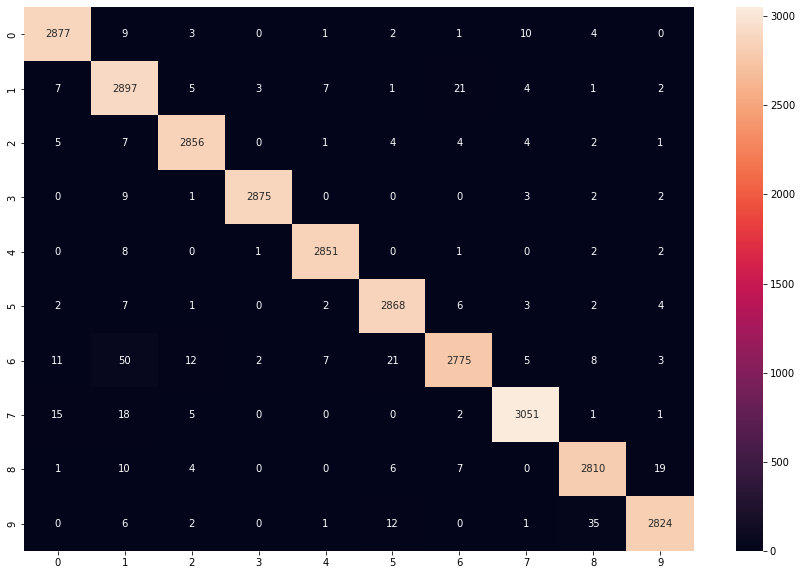

In [ ]:
# visualising the confusion matrix
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot = True, fmt='g')
plt.show()

In [ ]:
def predict(text):
  x = vec.transform([text]).toarray() # converting text to bag of words model (Vector)
  lang = model.predict(x) # predicting the language
  lang = le.inverse_transform(lang) # finding the language corresponding the the predicted value
  print(lang[0])

In [ ]:
predict("menurutku film movie sangat indah")

lat


## Tfidf -> LSTM

In [ ]:
# Word Embedding

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# vec = CountVectorizer(max_features=20000, ngram_range=(1, 1))
vec = TfidfVectorizer(max_features=500, ngram_range=(1, 5), analyzer='char')
X = vec.fit_transform(X_c).toarray()
X.shape

(291160, 500)

In [ ]:
import pickle
with open('tfidf-lstm-13.pickle', 'wb') as handle:
    pickle.dump(vec, handle)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y = encoder.fit_transform(y)
y.shape

(291160, 10)

In [ ]:
print(X.shape)
print(y.shape)

(291160, 500)
(291160, 10)


In [ ]:
# Train-Test = 90%-10%

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=True, random_state=5816)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(262044, 500)
(262044, 10)
(29116, 500)
(29116, 10)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

def build_model(X, y):
    model = Sequential()
    model.add(LSTM(128, input_shape=(500, 1)))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X, y, batch_size=128, epochs=5)
    return model

In [ ]:
model = build_model(X_train, y_train)

Epoch 1/5
2048/2048 [==============================] - 209s 99ms/step - loss: 1.1707 - accuracy: 0.6035
Epoch 2/5
2048/2048 [==============================] - 202s 99ms/step - loss: 0.5557 - accuracy: 0.8206
Epoch 3/5
2048/2048 [==============================] - 203s 99ms/step - loss: 0.4204 - accuracy: 0.8646
Epoch 4/5
2048/2048 [==============================] - 201s 98ms/step - loss: 0.3481 - accuracy: 0.8887
Epoch 5/5
2048/2048 [==============================] - 202s 99ms/step - loss: 0.3039 - accuracy: 0.9038


In [ ]:
model.save('tfidf-lstm-model-13.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 67,850
Trainable params: 67,850
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
import numpy as np
y_test_max = np.argmax(y_test, axis=1)
y_pred_max = np.argmax(y_pred, axis=1)
y_test_lang = encoder.classes_[y_test_max]
y_pred_lang = encoder.classes_[y_pred_max]

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

ac = accuracy_score(y_test_lang, y_pred_lang)
cm = confusion_matrix(y_test_lang, y_pred_lang)
cr = classification_report(y_test_lang, y_pred_lang)

In [ ]:
print("Accuracy is :", ac)
print(cr)

Accuracy is : 0.9052067591702156
              precision    recall  f1-score   support

         deu       0.90      0.95      0.93      2939
         eng       0.93      0.82      0.87      2906
         fra       0.84      0.97      0.90      2893
         gle       0.99      0.95      0.97      2942
         ind       0.99      0.93      0.96      2949
         ita       0.93      0.86      0.90      2808
         lat       0.87      0.90      0.88      2920
         nld       0.93      0.94      0.93      3007
         por       0.88      0.82      0.85      2860
         spa       0.82      0.90      0.86      2892

    accuracy                           0.91     29116
   macro avg       0.91      0.90      0.90     29116
weighted avg       0.91      0.91      0.91     29116



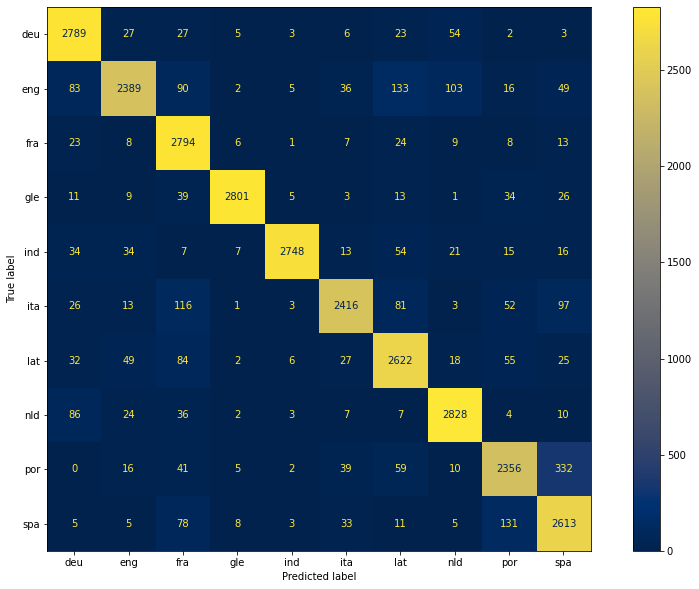

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cmp = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_)
fig, ax = plt.subplots(figsize=(15,10))
cmp.plot(cmap='cividis', ax=ax, values_format='')

In [ ]:
def predict(text):
  clean = regex_filter(text)
  x = vec.transform([text]).toarray()
  lang = model.predict(x)
  pred = np.zeros_like(lang)
  pred[np.arange(len(lang)), lang.argmax(1)] = 1
  pred_lang = encoder.inverse_transform(pred)
  print(pred_lang[0])

In [ ]:
predict("ada garansi resmi nyaman dipakai lama koneksi bluetooth kuat suaranya jernih desainnya modern")

ind


In [ ]:
predict("semuanya sangat baik")

ind


In [ ]:
predict("""One of the most unheralded great works of animation. Though it makes the most sophisticated use of the ""cut-out"" method of animation (a la ""South Park"")""")

eng
